In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns

import sklearn 
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

import imblearn
from imblearn.under_sampling import RandomUnderSampler

In [2]:
data_copy = pd.read_csv('processed_data.csv')
data = data_copy.copy()
data = data.drop_duplicates(subset = ['text'])

In [3]:
del data['title']
del data['text']
del data['text_without_stopwords']
del data['title_without_stopwords']
del data['overall_content']
del data['polarity_category']
del data['polarity_category_Neutral']
del data['polarity_category_Positive']

In [4]:
data['class'].value_counts()

0    21191
1    17453
Name: class, dtype: int64

There is slight imbalance in our dataset, which we will address later after the train-test split.

In [5]:
Y = data['class']
X = data[data.columns[data.columns != 'class']]

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 4222)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.25, random_state = 4222)

Final proportion is 60% train data, 20% validation data and 20% test data. 

In [7]:
undersample = RandomUnderSampler(sampling_strategy='majority')
x_train,y_train = undersample.fit_resample(x_train, y_train)

temp = pd.concat([x_train,y_train],axis = 1)
temp['class'].value_counts()

0    10444
1    10444
Name: class, dtype: int64

### Baseline Gaussian Naive Bayes' Model

In [8]:
GausNB = GaussianNB()
GausNB.fit(x_train, y_train)

y_pred_val = GausNB.predict(x_validation)
y_pred_test = GausNB.predict(x_test)

print("Performance on Validation set:")
print("Accuracy:", metrics.accuracy_score(y_validation, y_pred_val))
print("Precision:", metrics.precision_score(y_validation, y_pred_val))
print("Recall:",metrics.recall_score(y_validation, y_pred_val))
print("F1_score:", metrics.f1_score(y_validation, y_pred_val))
print("-------------------------------")

print("Performance on  Test set:")
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_test))
print("Precision:", metrics.precision_score(y_test, y_pred_test))
print("Recall:",metrics.recall_score(y_test, y_pred_test))
print("F1_score:", metrics.f1_score(y_test, y_pred_test))

Performance on Validation set:
Accuracy: 0.857290723250097
Precision: 0.9522546419098143
Recall: 0.7200573065902579
F1_score: 0.8200358949257628
-------------------------------
Performance on  Test set:
Accuracy: 0.8611722085651443
Precision: 0.952962962962963
Recall: 0.7311736288718386
F1_score: 0.8274642225438172


### Tuned Gaussian Naive Bayes' Model

Naive Bayes' assumes all features are independent of one another, which in the ideal case means every pair of features has zero correlation. While this assumption may be hard to hold in practice, we can avoid using features which have high correlation with one another as such a case implies that these features cannot be independent. 

In the context of our problem, we shall define to have high correlation if the absolute value of their correlation coefficient is greater than 0.9

<Axes: >

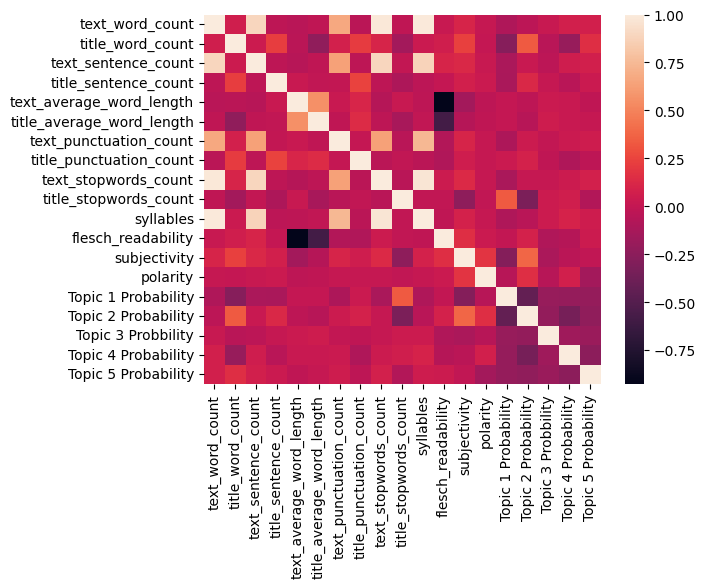

In [9]:
corr_matrix = X.corr()
sns.heatmap(corr_matrix)

In [10]:
rows, columns = X.shape
fields = list(X.columns)

fields

['text_word_count',
 'title_word_count',
 'text_sentence_count',
 'title_sentence_count',
 'text_average_word_length',
 'title_average_word_length',
 'text_punctuation_count',
 'title_punctuation_count',
 'text_stopwords_count',
 'title_stopwords_count',
 'syllables',
 'flesch_readability',
 'subjectivity',
 'polarity',
 'Topic 1 Probability',
 'Topic 2 Probability',
 'Topic 3 Probbility',
 'Topic 4 Probability',
 'Topic 5 Probability']

In [11]:
correlation_values = corr_matrix.values
for i in range(columns):
    for j in range(i+1, columns): #correlation matrix is symmetric
        if abs(correlation_values[i,j]) > 0.9:
            print(fields[i] + " and " + fields[j])
        else:
            pass

text_word_count and text_stopwords_count
text_word_count and syllables
text_average_word_length and flesch_readability
text_stopwords_count and syllables


From the code above, it appears we have several features which have high correlations. They are 

1. text_word_count 
2. text_stopwords_count 
3. syllables 
4. text_average_word_length 
5. flesch_readability 

In [12]:
features_to_remove = ['text_word_count', 'text_stopwords_count', 'syllables',
                      'text_average_word_length', 'flesch_readability']
data = data.drop(features_to_remove, axis = 1)

In [13]:
Y_updated = data['class']
X_updated = data[data.columns[data.columns != 'class']]

In [14]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(X_updated, Y_updated, test_size = 0.2, random_state = 4222)
x_train2, x_validation2, y_train2, y_validation2 = train_test_split(x_train2, y_train2, test_size = 0.25, random_state = 4222)

In [15]:
undersample = RandomUnderSampler(sampling_strategy='majority')
x_train2,y_train2 = undersample.fit_resample(x_train2, y_train2)

temp = pd.concat([x_train2,y_train2],axis = 1)
temp['class'].value_counts()

0    10444
1    10444
Name: class, dtype: int64

In [16]:
GausNB.fit(x_train2, y_train2)

y_pred_val2 = GausNB.predict(x_validation2)
y_pred_test2 = GausNB.predict(x_test2)

print("Performance on Validation set:")
print("Accuracy:", metrics.accuracy_score(y_validation2, y_pred_val2))
print("Precision:", metrics.precision_score(y_validation2, y_pred_val2))
print("Recall:",metrics.recall_score(y_validation2, y_pred_val2))
print("F1_score:", metrics.f1_score(y_validation2, y_pred_val2))
print("-------------------------------")

print("Performance on  Test set:")
print("Accuracy:", metrics.accuracy_score(y_test2, y_pred_test2))
print("Precision:", metrics.precision_score(y_test2, y_pred_test2))
print("Recall:",metrics.recall_score(y_test2, y_pred_test2))
print("F1_score:", metrics.f1_score(y_test2, y_pred_test2))

Performance on Validation set:
Accuracy: 0.9023159529046448
Precision: 0.9237682057638674
Recall: 0.8541547277936963
F1_score: 0.887598630340926
-------------------------------
Performance on  Test set:
Accuracy: 0.9015396558416354
Precision: 0.9258801729462631
Recall: 0.8519465757317419
F1_score: 0.8873760544620394


We now repeat the model training as per what we did above, but this time finding best var_smoothing parameter. In the Gaussian Naive Bayes' model above, we used the default parameter value of $10^{-9}$.

In [17]:
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=5, 
                                    random_state=4222)

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB_tuned = GridSearchCV(estimator = GausNB,
                           param_grid = params_NB,
                           cv = cv_method, 
                           verbose = 1,
                           scoring = 'accuracy')

gs_NB_tuned.fit(x_train2, y_train2)
gs_NB_tuned.best_params_

Fitting 25 folds for each of 100 candidates, totalling 2500 fits


{'var_smoothing': 4.328761281083053e-06}

In [18]:
y_pred_val3 = gs_NB_tuned.predict(x_validation2)
y_pred_test3 = gs_NB_tuned.predict(x_test2)

print("Performance on Validation set:")
print("Accuracy:", metrics.accuracy_score(y_validation2, y_pred_val3))
print("Precision:", metrics.precision_score(y_validation2, y_pred_val3))
print("Recall:",metrics.recall_score(y_validation2, y_pred_val3))
print("F1_score:", metrics.f1_score(y_validation2, y_pred_val3))
print("-------------------------------")

print("Performance on  Test set:")
print("Accuracy:", metrics.accuracy_score(y_test2, y_pred_test3))
print("Precision:", metrics.precision_score(y_test2, y_pred_test3))
print("Recall:",metrics.recall_score(y_test2, y_pred_test3))
print("F1_score:", metrics.f1_score(y_test2, y_pred_test3))

Performance on Validation set:
Accuracy: 0.9117609005045931
Precision: 0.9409547738693468
Recall: 0.8584527220630372
F1_score: 0.8978124063530117
-------------------------------
Performance on  Test set:
Accuracy: 0.9078794151895458
Precision: 0.9351937984496124
Recall: 0.8570616652458085
F1_score: 0.8944246737841044
